In [1]:
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from src.lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### Data loading

In [2]:
data_dict, int_label_pos_map = load_data_dict(mat_path, patients_list, phase_labels, param_keys_list)

### Per Patient, phase snapshots

In [5]:
patient = 'Pat_02'
phase = 'rsPre'
#
corr_net_filt = dict(threshold=0)
#
data_pat_phase = data_dict[patient][phase]
data_pat_phase_ts = data_pat_phase['data'][:, :5000]
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']
#

In [8]:
def compute_pc1_over_time(eeg: np.ndarray,
                          fs: float):
    """
    Compute the first principal component of
    an N×T EEG time series.

    Parameters
    ----------
    eeg : np.ndarray, shape (n_channels, n_times)
        Raw EEG data.
    fs : float
        Sampling rate in Hz.

    Returns
    -------
    times : np.ndarray, shape (n_times,)
        Time vector in seconds.
    pc1 : np.ndarray, shape (n_times,)
        First principal component amplitude at each time point.
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # 1. Transpose to (n_times, n_channels)
    X = eeg.T

    # 2. Standardize channels
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    # 3. PCA → 1st component
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(Xz).ravel()

    # 4. Time vector
    times = np.arange(pc1.size) / fs
    return times, pc1

def compute_pc1_explained_over_time(eeg: np.ndarray,
                                    fs: float):
    """
    Compute and (optionally) plot, for each time point, the fraction of
    total signal power explained by the first principal component.

    Parameters
    ----------
    eeg : np.ndarray, shape (n_channels, n_times)
        Raw EEG data.
    fs : float
        Sampling rate in Hz.

    Returns
    -------
    times : np.ndarray, shape (n_times,)
        Time vector in seconds.
    explained_ratio : np.ndarray, shape (n_times,)
        Fraction of power explained by PC1 at each time point.
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # 1. Transpose to (n_times, n_channels)
    X = eeg.T

    # 2. Standardize channels
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    # 3. Fit PCA and grab the first component
    pca = PCA(n_components=10)
    pca.fit(Xz)
    w = pca.components_[0]       # unit‐length vector of shape (n_channels,)

    # 4. Project each time point onto PC1
    #    dot = Xz @ w gives the scalar projection at each time
    dot = Xz.dot(w)              # shape: (n_times,)

    # 5. Compute power explained / total power at each time
    explained_power = dot**2                 # power in the projection
    total_power     = np.sum(Xz**2, axis=1)  # total power in z-scored channels
    explained_ratio = explained_power / total_power
    times = np.arange(explained_ratio.size) / fs
    return times, explained_ratio

def compute_explained_over_time(eeg: np.ndarray,
                                fs: float,
                                n_components: int = 1,
                                plot: bool = True, zorder: int = 1):
    """
    Compute (and optionally plot) the per-time-point fraction of
    total signal power explained by the first `n_components` principal components.

    Parameters
    ----------
    eeg : np.ndarray, shape (n_channels, n_times)
        Raw EEG data.
    fs : float
        Sampling rate in Hz.
    n_components : int, default=1
        How many PCA components to include in the projection subspace.
    plot : bool, default=True
        If True, plot the explained‐power ratio over time.

    Returns
    -------
    times : np.ndarray, shape (n_times,)
        Time vector in seconds.
    ratio : np.ndarray, shape (n_times,)
        Fraction of power explained by the first `n_components` PCs at each time.
    evr : np.ndarray, shape (n_components,)
        Global explained_variance_ratio_ for each of the `n_components` PCs.
    evr_cum : np.ndarray, shape (n_components,)
        Cumulative explained variance ratio over the first k PCs.
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # 1. reshape to (n_times, n_channels)
    X = eeg.T

    # 2. z-score each channel
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    # 3. fit PCA and grab the first k component vectors
    pca = PCA(n_components=n_components)
    pca.fit(Xz)
    W = pca.components_              # shape: (k, n_channels)

    # 4. project each timepoint into k-dim subspace and compute power
    projs = Xz.dot(W.T)              # shape: (n_times, k)
    explained_power = np.sum(projs**2, axis=1)
    total_power     = np.sum(Xz**2, axis=1)
    ratio = explained_power / total_power

    # 5. time axis
    times = np.arange(ratio.size) / fs

    # 6. optional plot
    if plot:
        plt.plot(times, ratio, lw=0.5, zorder=zorder)

        # also show the global explained_variance_ratio_
        cum = np.cumsum(pca.explained_variance_ratio_)
        # print("Explained variance ratio per PC:", np.round(pca.explained_variance_ratio_, 3))
        # print("Cumulative explained variance:", np.round(cum, 3))

    return times, ratio, pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_)

100%|██████████| 6/6 [00:00<00:00, 28.12it/s]


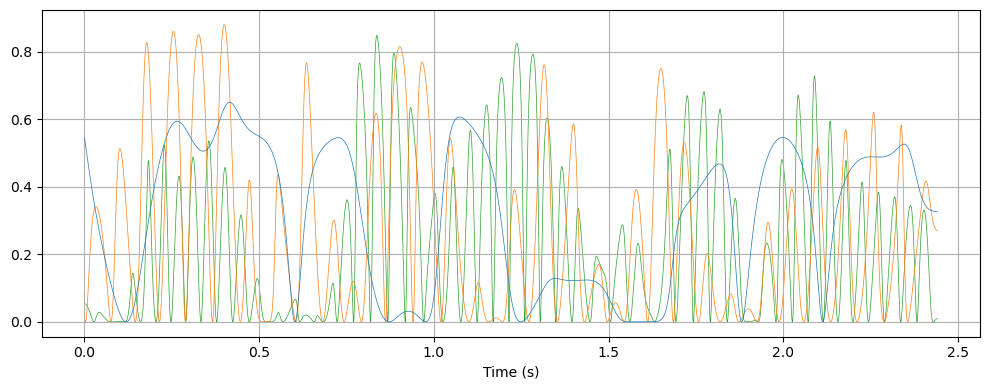

In [16]:
plt.figure(figsize=(10, 4))

for band_name, (low, high) in tqdm(BRAIN_BANDS.items()):
    filter_data = bandpass_sos(data_pat_phase_ts, low, high, fs, int(filter_order))
    if low < 10:
        compute_explained_over_time(filter_data[:20], fs, n_components=1, plot=True, zorder=1/low)
plt.xlabel("Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()
